# Why does the modified algorithm perform better?

- We know that by including an exploration step at the training data generation phrase (rollouts), we showed that the performance of the PbPI algorithm can be improved.
- This improved performance was observed while working with the 'Inverted Pendulum' problem.
- The exact modification was to select the two highest ranked actions with equal probability.
- By the analyses that we perform in this notebook, we try to understand why this happens as well as any logical extensions of this method to design a new PbPI algorithm which would demonstrate higher performance.

---
### Experiment Throught Process

- For this analysis, I will use a small initial state set of size 20. 
- The selected sample is a representative sample of the underlying state space (please refere to the **[initial state analysis](https://bit.ly/2MhMyJF)** to have more information).
- I will run the original and modified PbPI algorithm using this initial state set based on below configurations:
    - initial state size:
    - rollouts:
    - significance:
    - no. of runs: 

- I will observe the rankings of the actions in each rollout to have a better understanding how the modified algorithm works.
- I will also try expanding the action space to 5 and 9 actions and confirm the same performance improvement is observed even then.
- I will try to create different versions of the modified algorithm by changing the exploration step (e.g., select top 3 actions, with .3, .2, .1 probabily)

### Importing the required libraries/packages

In [1]:
import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

#from scipy.stats import rankdata as rd
from scipy import stats

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm
import os

import sys
sys.path.append('../scripts/')
from training import evaluations_per_config
sys.path.append('../notebooks/')

%load_ext autoreload
%autoreload 2

### Generating the initial state set

In [ ]:
def create_state_pool():
    """
    Create a pool of initial states to select states from.

    Returns:
        tuple (pandas.DataFrame, pandas.DataFrame) : Pandas dataframes having state value 
                                                      information of the stored initial states
    """

    # Initialize the gym environment and rest it
    env = gym.make('CustomCartPole-v0') 
    env.reset()

    # Empty vectors to store values
    obs_vec = []
    term_vec = []

    # Number of steps to execute in the environment
    step_count = 10000

    # Generate states by executing random actions (following a random policy)
    for step in tqdm.tqdm(range(step_count)):
        obs, reward, terminated, _ = env.step(env.action_space.sample())

        obs_vec.append(obs)
        term_vec.append(terminated)

        if terminated:
            env.reset()


    # Process the observed state values
    obs_vec = np.array(obs_vec).reshape(step_count,-1)
    term_vec  = np.array(term_vec ).reshape(step_count,-1)

    # Only pick the 'pendulum angle' and 'angular velocity' values
    obs_pend_angle_velo = obs_vec[:,[2,3]]
    
    # Save the full state space to create final state (w/ cart-position and cart-velocity)
    obs_full = obs_vec[:,:]    

    # Join the state observations with termination flag data
    obs_pend_angle_velo_w_flag = np.concatenate([obs_pend_angle_velo,term_vec],axis = 1)

    # Create a Pandas dataframe with the information
    obs_df = pd.DataFrame(obs_pend_angle_velo_w_flag
                        , columns=['pend_angle','angular_velo','flag'])
    obs_df.reset_index(inplace = True)
    obs_df.columns = ['step','pend_angle','angular_velo','flag']
    obs_df.flag.replace([0,1],['Not-Terminated','Terminated'],inplace=True) # Replace the termination flag values
    
    
    # Create a Pandas dataframe with complete state information
    obs_full_df = pd.DataFrame(obs_full
                        , columns=['cart_position', 'cart_velocity','pend_angle','angular_velo'])
    obs_full_df.reset_index(inplace = True)
    obs_full_df.columns = ['step','cart_position', 'cart_velocity','pend_angle','angular_velo']
    
    return obs_df, obs_full_df

# Generate the pool of states
obs_df, full_state_df =  create_state_pool()
obs_df.head()

I create the 'reduced version' of the state pool 
- by removing terminal states, and
- every four states that led to a terminal state

In [ ]:
# Append the 'episode number' and 'episodic step' values
#  to the states stored in the initial pool of states
episode_count = []
episodic_step = []

epi_step_count = 0
epi_count = 1

for idx, row in obs_df.iterrows():
    
    epi_step_count += 1   
        
    if row.flag == 'Terminated':
        episodic_step.append(epi_step_count)
        epi_step_count = 0
        
        episode_count.append(epi_count)
        epi_count +=1
        continue
        
    episode_count.append(epi_count)
    episodic_step.append(epi_step_count)
        
obs_df = pd.concat([obs_df
                    , pd.Series(episodic_step,name='episodic_step')
                    , pd.Series(episode_count ,name='episode_num')],axis=1)



# Identify number of steps to select from each episode (after removing 4 states leading to terminal state)
epi_n_epi_steps_fil_df = obs_df.groupby(['episode_num']).episodic_step.max().reset_index()
epi_n_epi_steps_fil_df.loc[:,'epi_steps_to_use'] = epi_n_epi_steps_fil_df.episodic_step.apply(lambda val: max(0,val-5))

obs_df = obs_df.merge(right = epi_n_epi_steps_fil_df.loc[:,['episode_num', 'epi_steps_to_use']]
                     , right_on='episode_num'
                     , left_on = 'episode_num'
                     , how = 'left')


# Empty list to store the selected rows for the reduced dataset
filter_df_rows = []

# Iterate over rows; only select the states/rows accoding to 'epi-steps-to-use' values
for idx, row in obs_df.iterrows():
    
    if row.episodic_step <= row.epi_steps_to_use:
        filter_df_rows.append(row)
    
obs_df_reduced = pd.concat(filter_df_rows,axis=1).T

obs_df_reduced.head(10)

In [ ]:
# Draw a random sample of size 20  from the 'reduced' initial state pool
np.random.seed(15)

sample_size = 20

idx = np.random.choice(obs_df_reduced.index.values, size=sample_size)
init_state_sample = obs_df_reduced.loc[obs_df_reduced.index.isin(idx),['pend_angle','angular_velo']]
init_state_sample.reset_index(drop=True, inplace=True)

In [ ]:
# inspect the plot
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(init_state_sample.pend_angle
             , hist=True
             , ax=ax
             , color='green'
             , bins = 20
             , label='pendulum angle')

sns.distplot(init_state_sample.angular_velo
             , hist=True
             , ax=ax
             , bins = 20
             , color='red'
             , label='anglular velocity')

ax.legend()
ax.set_xlabel("")
ax.set_title(f"initial state sample of size {sample_size}")

plt.tight_layout()
plt.show()

In [ ]:
def compute_full_state(df_row):
    """
    Generate the 'cart velocity' state value for a given pair of 'pendulum angle' and 'angular velocity' state values
    using the complete pool of state dataset.

    Args:
        pandas.Series : A row of a pandas dataframe which include the 
                            - pendulum angle and angular velocity of a state
                            - upper and lower bounds computed on the above two state values

    Returns:
        tuple : a complete state of the environment
                    - (cart position = 0, cart velocity, pendulum angle, angular velocity)
    """

    pend_angle = df_row[0] # First column contains the generated pendulum angle
    angular_vel = df_row[1] # Second column contains the generated angular velocity

    upper_pend_angle_b = df_row[2]    # Third column contains the computed uppre bound on the pendulum angle
    lower_pend_angle_b = df_row[3]   # Fourth column contains the computed lower bound on the pendulum angle

    upper_angu_vel_b = df_row[4]    # Fifth column contains the computed uppre bound on the angular velocity
    lower_angu_vel_b = df_row[5]    # Fourth column contains the computed lower bound the angular velocity

    cart_vel = np.array(full_state_df.loc[(full_state_df.pend_angle <= upper_pend_angle_b) & \
                                            (full_state_df.pend_angle >= lower_pend_angle_b) & \
                                            (full_state_df.angular_velo <= upper_angu_vel_b) & \
                                            (full_state_df.angular_velo >= lower_angu_vel_b) ,'cart_velocity'].values).mean()

    cart_posi = 0 # set cart-position to be zero

    return (cart_posi, cart_vel, pend_angle, angular_vel)


def create_full_state_sample(df):
    """
    Generate a dataset with all state value variables.

    Args:
        Pandas.DataFrame : Dataset having 'pendulum angle' and 'angular velocity' state values

    Returns:
        Pandas.DataFrame : Dataset with all four state values (cart position, cart velocity, pendulum angle, angular velocity)
    """

    df.loc[:,'pend_angle_b_upper'] = df.pend_angle.apply(lambda val: val+0.05)
    df.loc[:,'pend_angle_b_lower'] = df.pend_angle.apply(lambda val: val-0.05)

    df.loc[:,'angular_velo_b_upper'] = df.angular_velo.apply(lambda val: val+0.05)
    df.loc[:,'angular_velo_b_lower'] = df.angular_velo.apply(lambda val: val-0.05)

    # Create the final right-skewewd inititial state set
    full_state_value_pairs = []

    for idx, row in df.iterrows():
        full_state_value_pairs.append(compute_full_state(row))

    final_df = pd.DataFrame(np.array(full_state_value_pairs), columns=['cart_position'	,'cart_velocity','pend_angle','angular_velo'])
    
    return final_df

init_state_sample_final = create_full_state_sample(init_state_sample)
init_state_sample_final.to_csv(f'../data/input/init_state_sample_s_{sample_size}.csv', index=False)


#### Display the created 20 initial states

In [ ]:
init_states_S = init_state_sample_final.values.reshape(sample_size,4,1,1)

env = gym.make('CustomCartPole-v0')
fig = plt.figure(figsize=(sample_size,2*int(sample_size/2)))

for i in range(sample_size):
    env.reset(init_state = init_states_S[i]) # set state
    fig.add_subplot(int(sample_size/4),5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

### Running original PbPI algorithm on the initial state set

Now having created the initial state set, let's first run the PbPI **original algorithm**, without exploration step.


In [4]:
# Configs to test
N_STATES = 20
configs = {'S': [N_STATES]
          , 'init_state_path': f'../data/input/init_state_sample_s_{str(N_STATES)}.csv'
          , 'Actions' : [3]
          , 'Roll-outs': [10]
          , 'Significance' : [0.1]
          }

Evaluations:   0%|          | 0/1 [00:00<?, ?it/s]
Currently evaluated configs:
 Samples: 20 | Actions: 3 | Roll-outs: 10 | Significance: 0.1

Runs:   0%|          | 0/10 [00:00<?, ?it/s]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 160.4375
                         - Max. return : 839.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 146.6035
                         - Max. return : 231.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 13.3785
                         - Max. return : 28.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 21.16
  

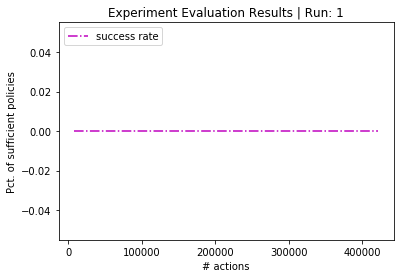


Runs:  10%|█         | 1/10 [35:23<5:18:34, 2123.87s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 119.9955
                         - Max. return : 367.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 21.6525
                         - Max. return : 52.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 14.9375
                         - Max. return : 28.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 14.827
                         - Max. return : 42.0
                         - Min. return : 6.0
                         - Successful epis

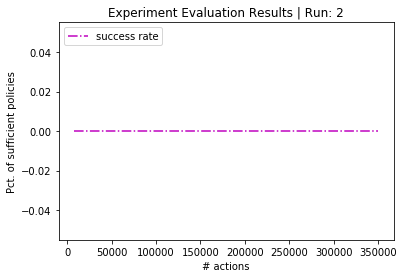


Runs:  20%|██        | 2/10 [1:02:03<4:22:12, 1966.50s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 36.642
                         - Max. return : 162.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 19.5265
                         - Max. return : 56.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 25.3345
                         - Max. return : 123.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 35.7425
                         - Max. return : 137.0
                         - Min. return : 6.0
                         - Successful e

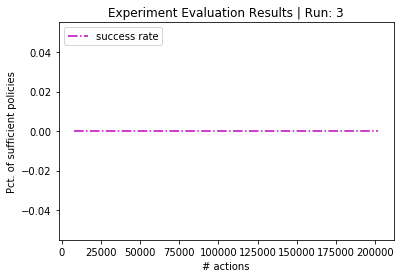


Runs:  30%|███       | 3/10 [1:13:06<3:03:48, 1575.56s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 36.8215
                         - Max. return : 103.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 17.7505
                         - Max. return : 46.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 15.075
                         - Max. return : 40.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 109.9825
                         - Max. return : 197.0
                         - Min. return : 6.0
                         - Successful e

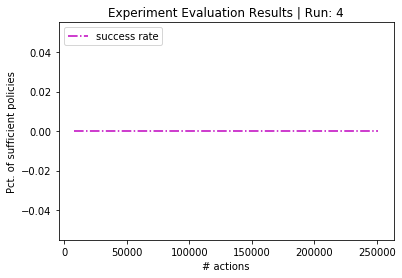


Runs:  40%|████      | 4/10 [1:22:44<2:07:37, 1276.24s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 140.604
                         - Max. return : 304.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 80.8525
                         - Max. return : 176.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 22.6285
                         - Max. return : 157.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 96.8895
                         - Max. return : 201.0
                         - Min. return : 5.0
                         - Successful

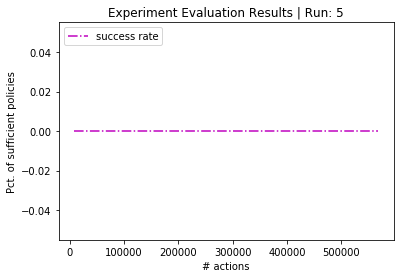


Runs:  50%|█████     | 5/10 [1:43:43<1:45:55, 1271.09s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 40.522
                         - Max. return : 237.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 90.4665
                         - Max. return : 204.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 224.0235
                         - Max. return : 651.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 213.896
                         - Max. return : 288.0
                         - Min. return : 5.0
                         - Successful

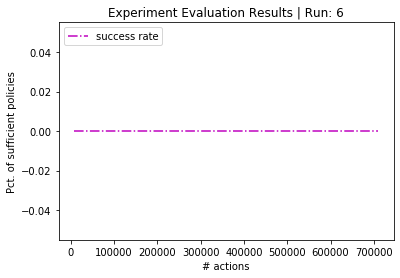


Runs:  60%|██████    | 6/10 [2:08:29<1:29:02, 1335.63s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 50.3765
                         - Max. return : 213.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 18.0255
                         - Max. return : 39.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 27.0675
                         - Max. return : 120.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 114.1575
                         - Max. return : 221.0
                         - Min. return : 6.0
                         - Successful

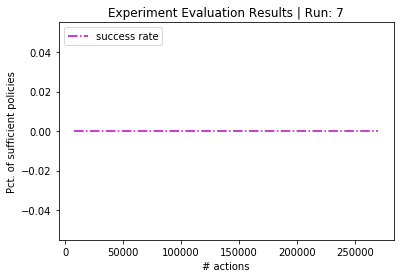


Runs:  70%|███████   | 7/10 [2:15:54<53:25, 1068.53s/it]  
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 82.625
                         - Max. return : 210.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 39.8895
                         - Max. return : 159.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 38.87
                         - Max. return : 230.0
                         - Min. return : 5.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 81.7555
                         - Max. return : 254.0
                         - Min. return : 6.0
                         - Successful ep

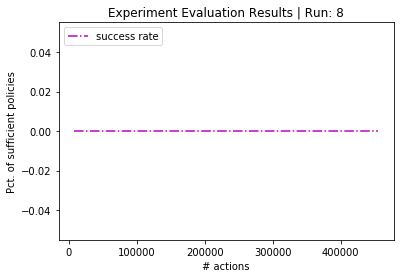


Runs:  80%|████████  | 8/10 [2:28:55<32:44, 982.23s/it] 
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 38.4425
                         - Max. return : 243.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 38.5905
                         - Max. return : 108.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 14.534
                         - Max. return : 35.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 17.821
                         - Max. return : 40.0
                         - Min. return : 5.0
                         - Successful episo

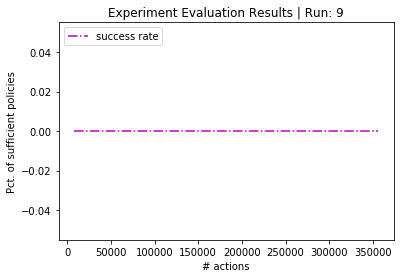


Runs:  90%|█████████ | 9/10 [2:56:32<19:44, 1184.57s/it]
Policy Iteration: 1 - Evaluation results:
                         - Avg. return : 32.282
                         - Max. return : 90.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 2 - Evaluation results:
                         - Avg. return : 154.3075
                         - Max. return : 233.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 3 - Evaluation results:
                         - Avg. return : 14.2155
                         - Max. return : 28.0
                         - Min. return : 6.0
                         - Successful episodes : 0.0% 


Policy Iteration: 4 - Evaluation results:
                         - Avg. return : 17.5495
                         - Max. return : 44.0
                         - Min. return : 6.0
                         - Successful epis

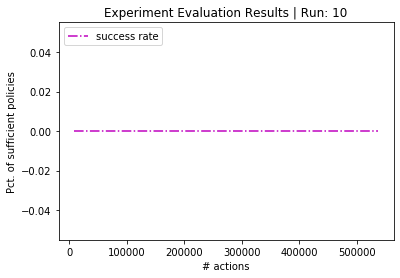


Runs: 100%|██████████| 10/10 [3:15:51<00:00, 1175.20s/it]


In [5]:
# Original algorithm
agg_results = []

eval_count = len(configs['S'])*len(configs['Actions'])*len(configs['Roll-outs'])*len(configs['Significance'])

pbar_evals = tqdm.tqdm(total=eval_count, desc="Evaluations", leave=False)

for sample_size in configs['S']:
        
    for rollout_max in configs['Roll-outs']:

        for sig_lvl in configs['Significance']:

            run_results = evaluations_per_config(s_size = sample_size
                                                , n_actions = configs['Actions'][0]
                                                , max_n_rollouts = rollout_max
                                                , sig_lvl = sig_lvl
                                                , runs_per_config = 10
                                                , max_policy_iter_per_run = 10
                                                , init_state_path = configs['init_state_path']
                                                , off_policy_explr = False # Original algo.

                                                , rollout_tracking = False
                                                , dataset_tracking = False
                                                , train_plot_tracking = False
                                                , eval_summary_tracking = True 
                                                , experiment_eval_plot = True)

            agg_results.append(run_results)

            pbar_evals.update(1)
                
pbar_evals.close()

In [3]:
# Modified algorithm
agg_results = []

eval_count = len(configs['S'])*len(configs['Actions'])*len(configs['Roll-outs'])*len(configs['Significance'])

pbar_evals = tqdm.tqdm(total=eval_count, desc="Evaluations", leave=False)

for sample_size in configs['S']:
        
    for rollout_max in configs['Roll-outs']:

        for sig_lvl in configs['Significance']:

            run_results = evaluations_per_config(s_size = sample_size
                                                , n_actions = configs['Actions'][0]
                                                , max_n_rollouts = rollout_max
                                                , sig_lvl = sig_lvl
                                                , runs_per_config = 10
                                                , max_policy_iter_per_run = 10
                                                , init_state_path = configs['init_state_path']
                                                , off_policy_explr = True # Modified algo.

                                                , rollout_tracking = False
                                                , dataset_tracking = False
                                                , train_plot_tracking = False
                                                , eval_summary_tracking = True 
                                                , experiment_eval_plot = True)

            agg_results.append(run_results)

            pbar_evals.update(1)
                
pbar_evals.close()

NameError: name 'configs' is not defined